In [1]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.distance import PairwiseDistance
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from tqdm import tnrange
from tqdm import tqdm_notebook

In [2]:
cuda = torch.device('cuda')
cpu = torch.device('cpu')

In [3]:
class Images(torch.utils.data.Dataset):
    def __init__(self):
        D = np.r_[pd.read_csv("./mnist1.csv").to_numpy(), pd.read_csv("./mnist2.csv").to_numpy()]
        self.X = torch.Tensor(D[:, :-1].reshape(70000, 1, 28, 28))/255
        self.y = torch.Tensor(D[:, -1:])
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :, :, :], self.y[idx, 0]
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)

In [4]:
Img = Images()
Img.to(cuda)

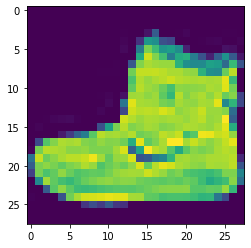

In [5]:
plt.imshow(Img[0][0].to(torch.device('cpu')).reshape(28,28));

In [6]:
ratio = 0.001
train, valid = torch.utils.data.random_split(Img, [int(len(Img)*(1 - ratio)), int(len(Img)*ratio)])

In [7]:
dataLoader = torch.utils.data.DataLoader(train, batch_size=500)

# MSE

In [8]:
def onehot(y):
    ret = torch.zeros(y.shape[0], 10)
    ret[torch.arange(y.shape[0]), y.long()] = 1
    return ret

In [9]:
def CE(y, y_pred):
    y = onehot(y) == 1
    return -torch.log(y_pred[y]).sum()# - torch.log(1 - y_pred[~y]).sum() + 0

# KMeans

In [10]:
def dist2(X, Y):
    Xsq = X.pow(2).sum(1, keepdim=True)
    Ysq = Y.pow(2).sum(1, keepdim=True)
    return Xsq + Ysq.T - 2*X @ Y.T

In [31]:
class KMeans(nn.Module):
    def __init__(self, X, k):
        super(KMeans, self).__init__()
        self.M = nn.Parameter(X[torch.randperm(X.shape[0])[:k], :].clone())
        self.newM = nn.Parameter(torch.zeros_like(self.M.data))
        self.n = nn.Parameter(torch.zeros(k))
        self.iteration_cost = 0
        
    def accumulate(self, X):
        D, Ind = dist2(X, self.M).min(1)
        self.iteration_cost += D.sum()
        for i in range(self.M.shape[0]):
            self.newM[i, :] += X[Ind == i, :].sum(0)
            self.n[i] += torch.sum(Ind == i)
            
    def step(self):
        self.M.data[self.n!=0, :] = (self.newM[self.n!=0, :].T/self.n[self.n!=0]).T
        self.newM.zero_()
        self.n.zero_()
        ret = self.iteration_cost
        self.iteration_cost = 0
        return ret
        

In [32]:
models = [KMeans(X.reshape(X.shape[0], 28*28)[y == i, :].to(cpu), 10).to(cuda) for i in range(10)]

In [33]:
EPOCHS = 100
for e in tnrange(EPOCHS):
    for X, y in dataLoader:
        for i in range(10):
            X_i = X.view(X.shape[0], 28*28)[y.long() == i, :]
            models[i].accumulate(X_i)
    for i in range(10): print(models[i].step())

tensor(263683.3750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(175551.4375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(294447.4375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(268304.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(271634.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(320105.8125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(270652.1562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(190026.0938, device='cuda:0', grad_fn=<AddBackward0>)
tensor(422911.8438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(276481.2188, device='cuda:0', grad_fn=<AddBackward0>)
tensor(159449.9844, device='cuda:0', grad_fn=<AddBackward0>)
tensor(108365.8594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183054.9375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(152970.8906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(165702.0781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(202434.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(173521.3906, devi

tensor(223007.5469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(157843.4688, device='cuda:0', grad_fn=<AddBackward0>)
tensor(146509.2188, device='cuda:0', grad_fn=<AddBackward0>)
tensor(96722.5781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(164678.4375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(139303.5312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(151617.5469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185507.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(164375.1719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(104337.6172, device='cuda:0', grad_fn=<AddBackward0>)
tensor(223007.3438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(157837.1094, device='cuda:0', grad_fn=<AddBackward0>)
tensor(146501.2031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(96720.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(164674.3906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(139292.2656, device='cuda:0', grad_fn=<AddBackward0>)
tensor(151616.1719, device

KeyboardInterrupt: 

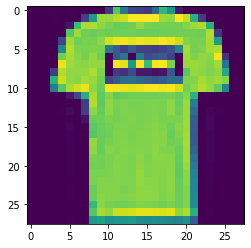

In [160]:
plt.imshow(Img[1][0].reshape(28,28).to(cpu))

In [228]:
Img[0][1]

tensor(9., device='cuda:0')

In [34]:
dist2(Img[0][0].reshape(1, 784), model.M)

NameError: name 'model' is not defined

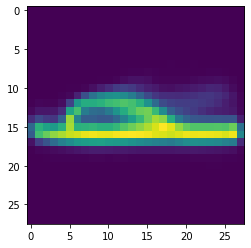

In [49]:
plt.imshow(models[5].M.data[7].reshape(28,28).to(cpu))

In [135]:
model.forward(X.reshape(X.shape[0], 28*28)).max(1)[0].mean()

tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)